In [1]:
# Import libraries to use 
import numpy as np
import matplotlib.pyplot as plt
import math       
import scipy as sp
import scipy.optimize
import subprocess # Library to run ngspice on shell
import seaborn as sns # Library to change the color palette for plots
import random
import timeit # To time computing time
import warnings # To supress warnings
import string

In [2]:
def readdata(filename,Labels,Data_points):
    out = subprocess.run(['ngspice', '-b', filename], 
                         stdout=subprocess.PIPE,  stderr=subprocess.PIPE)
    
    name = filename[:-4]+'.txt' # Name of the file to save output from ngspice
    
    # This saves output data in txt file
    with open(name, 'w') as output:
        for line in out.stdout.decode('ascii').split('\n'):
            output.write(line+'\n') # Writing output lines 
    
    # We get the data into an array 
    fill = np.zeros (len(Labels), dtype=int)
    
    f = open (name, 'r');
    src = []
    while True:  
        line = f.readline()
        if not line: break  # end of file
        if line[0] == '#':
            continue # treat next line
        src.append(line)

    #print(src)
    data = np.zeros ([Data_points, len(Labels)])

    for line in src:
        #print line
        # Here we initialize the ngspice data array
        '''
        if line.startswith('No.'):
            temp_list = line.split(":")
            Data_points = int(temp_list[-1])
            #print(Data_points)
            data = np.zeros ([Data_points, len(Labels)])
            #print(data.shape)
        '''
        
        
        # Here we determine the indexes for the current columns
        if line.startswith('Index'):
            temp_list = [str(x) for x in line.split()]
            #print(temp_list)
            n_columns = len (temp_list)
            index = np.zeros(n_columns, dtype = int)

            for j in range(n_columns):
                index [j] = Labels.index(temp_list[j])
            #print index

        # if the line starts with a number, we treat it as the data line
        if line[0].isdigit():
            temp_data = [float(x) for x in line.split()]

            for c in range(n_columns):
                r = fill[c]
                #print(r, index [c])

                data [r][index[c]] = temp_data [c]

                fill [c] = fill [c] + 1
                if fill [c] == Data_points:
                    fill [c] = 0
    return data

In [3]:
# Definition to generate netlist for an arbitraty number of sections

def generatingnetlist(filename,ns,ntapes,Ic,n,Rc,Imax):
    
    nodes = ((ns+1)*ntapes)+1 # Number of nodes
    num_rc = (ns+1)*(ntapes-1) # Total Number of contact resistances
    # Printing the labels of the elements to read current for this case
    Labels = ['Index','i-sweep']
    
    # Voltage in nodes
    for i in range(nodes):
        Labels.append(f'v({i+1})')
    # Contact resistances
    for i in range(num_rc):
        Labels.append(f'@r{i+1}[i]')
    # Voltage sources
    for i in range(ntapes):
        for j in range(ns):
            Labels.append(f'@b_{i+1}_{j+1}[i]')

    probe = ''
    for i in range(len(Labels)-2):
        probe = probe + Labels[i+2]+' '
    #print(probe)
    
    # Patameters for the model
    Rt = 5E-7 # Terminal resistance
    #n = 30 # n-value
    Ec = 100E-6 # Electric field criterion
    L = 0.1 # [m] length of tape
    Vc = Ec*L
    #Imax = 250 # Maximum current
    step = 1 # Step current
    Data_points = int(Imax/step + 1)

    # Start writing netlist
    with open(filename, 'w') as output:
        output.write(f'* Netlist for 2 tapes with contact resistance\n')
        output.write('I1 0 1 100\n') # Current source

        # Terminal resistances
        for i in range(ntapes):
            output.write(f'rt_i_{i+1} 1 {2+(ns+1)*i} {Rt/2}\n')
            output.write(f'rt_f_{i+1} {((ns+1)*(i+1))+1} 0 {Rt/2}\n')
        # Contact resistances
        for i in range(num_rc):
            output.write(f'r{i+1} {ns+3+i} {i+2} {Rc[i]}\n')

        # Voltage sources
        for i in range(ntapes):
            for j in range(ns):
                output.write(f'b_{i+1}_{j+1} {2+(ns+1)*i+j} {3+(ns+1)*i+j} V={Vc/ns}*pow((I(b_{i+1}_{j+1})/{Ic[i,j]}),{n[i,j]})\n')
        
        output.write('.options savecurrents\n')
        output.write(f'.dc I1 0 {Imax} 1\n')
        output.write('.print dc '+probe+'\n')
        output.write('.end\n')
    return Labels,Data_points
        

In [4]:
# Fitting model including resistance 
def model_func(I,Rt,Ic,n):
    V0 = 100E-6 # Considering the criterion 100uV/m with length = 1 m
    return Rt*I+V0*(I/Ic)**n

def fit_exp(I,V,Rt0,Ic0,n0): #(Rt0,Ic0,n0) are guessed initial values 
    opt_parms, parm_cov = sp.optimize.curve_fit(model_func, I, V,(Rt0,Ic0,n0))
    Rt,Ic,n = opt_parms
    return Rt,Ic,n

# Analizing two tapes cable with a defect in a 3-section model

- Average Ic and n value of all superconducting voltage sources is 95.13 A and 32.45, respectively.
- The defect is on tape 2 at the center. Ic and n value are 40 A and 16.
* These values are obtained from measurement.
- Length of the tape 10 cm. 

<img src="2tapesdefect.png">

Ic
 [[95.13 95.13 95.13]
 [95.13 40.   95.13]]
n
 [[32.45 32.45 32.45]
 [32.45 16.   32.45]]
Imax = 237.825
Rc 1e-08: Rt = 2.504e-07, Ic = 155.1493, n = 24.6759, Fit-error = 3.187e-07



<IPython.core.display.Javascript object>


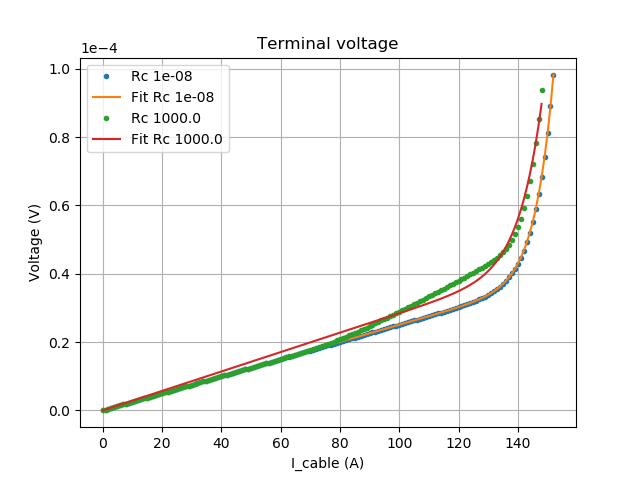

Rc 1000.0: Rt = 2.84e-07, Ic = 153.7671, n = 19.3744, Fit-error = 2.06978e-05



In [5]:
%matplotlib notebook
ntapes = 2
ns = 3
num_rc = (ns+1)*(ntapes-1)
Ic_mean = 95.13 # [A]
Ic_defect = 40 # [A]
n_mean = 32.45 
n_defect = 16
Ic = np.zeros((ntapes,ns))+Ic_mean
Ic[1,1]= Ic_defect
n = np.zeros((ntapes,ns))+n_mean
n[1,1]= n_defect
print('Ic\n',Ic)
print('n\n',n)
Imax = ntapes*Ic_mean*1.25
print(f'Imax = {Imax}')

R_cvals = np.array([1E-8,1000])

for i in range(len(R_cvals)):
    filename = f'2 tapes/2 tapes - Rc {R_cvals[i]}.cir'
    Rc = np.zeros(num_rc)+R_cvals[i]

    Labels, Data_points = generatingnetlist(filename,ns,ntapes,Ic,n,Rc,Imax)

    data = readdata(filename,Labels,Data_points)
    
    Icable = data[:,1]
    Vt = data[:,2]
    #plt.plot(Icable,Vt,label = f'Rc {Rc[i]}')
    
    Vt_lim = []
    Icable_lim = []
    # Voltage limit
    for l in range(len(Vt)):
        if Vt[l] <= 100e-6: # Limit of the total voltage
            Vt_lim.append(Vt[l])
            Icable_lim.append(Icable[l])
    
    Vt_lim = np.array(Vt_lim)
    Icable_lim = np.array(Icable_lim)
    
    # Exponential fitting
    Rt0,Ic0,n0 = 0.5E-6,100,30 # Initial values to fit exponential part
    Rt_e,Ic_e,n_e = fit_exp(Icable_lim,Vt_lim,Rt0,Ic0,n0)
    #print(Rt_e,Ic_e,n_e)

    # Getting curve from fitting 
    Vt_fit_exp = model_func(Icable_lim,Rt_e,Ic_e,n_e)

    # Calculating fitting error
    Error = np.sqrt(sum((Vt_lim-Vt_fit_exp)**2))

    # Plotting
    print(f'Rc {R_cvals[i]}: Rt = {round(Rt_e,10)}, Ic = {round(Ic_e,4)}, n = {round(n_e,4)}, Fit-error = {round(Error,10)}\n')
    plt.plot(Icable_lim,Vt_lim,'.',label = f'Rc {R_cvals[i]}')
    plt.plot(Icable_lim,Vt_fit_exp,label = f'Fit Rc {R_cvals[i]}')
    #plt.plot(Icable_lim,Vt_fit_exp,label = f'Fit Rc {Rc[i]} 3S')
    #plt.plot(data[:,1],data[:,2],label = Labels[2]+f'{ns} sections- Rc {R_cvals[i]}')

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel('I_cable (A)')
plt.ylabel('Voltage (V)')
plt.title('Terminal voltage')
#plt.ylim(0,100E-6)
#plt.xlim(0,200)
plt.grid()
plt.legend()
plt.show()

# Plotting current through contact resistances

<IPython.core.display.Javascript object>


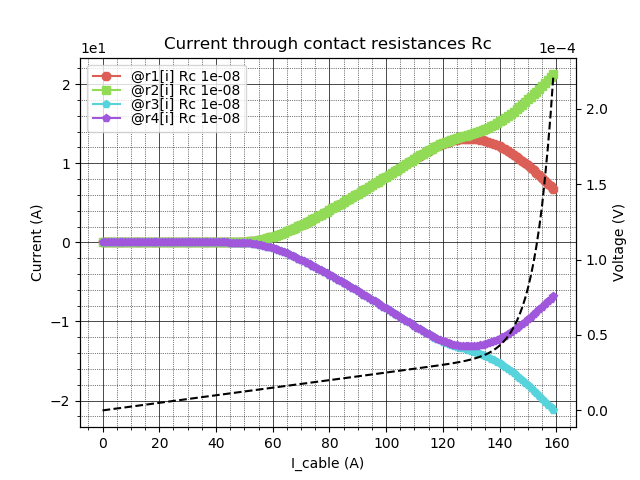

<IPython.core.display.Javascript object>


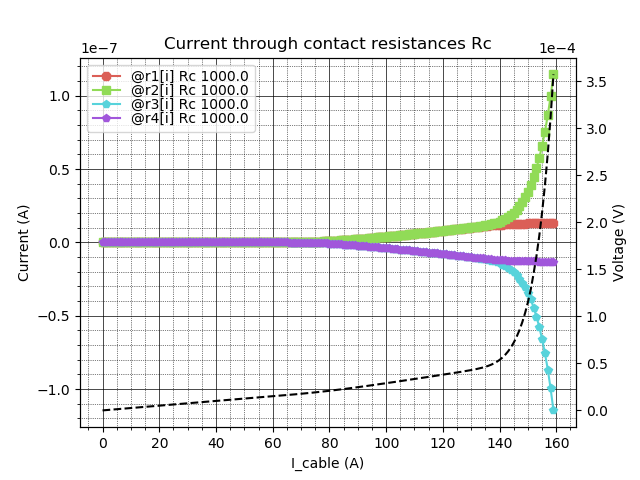

In [6]:
# Testing different values of contact resistance
sns.set_palette(sns.color_palette("hls", 4))
# Generating netlists and saving data
markers = ["8","s","p","p","*","."]

for i in range(len(R_cvals)):
    ns = 3 # Number of sections
    filename = f'2 tapes/2 tapes - Rc {R_cvals[i]}.cir'
    #generatenetlist(filename,Rc[i])
    dataf = readdata(filename,Labels,Data_points)
    lim_points = 160
    data = dataf[:lim_points]
    nc = 11
    fig, ax = plt.subplots()
    for j in range(ns+1):
        ax.plot(data[:,1],data[:,j+nc],marker = markers[j],label = Labels[j+nc]+f' Rc {R_cvals[i]}')
        
    ax.legend(labelspacing=0.001,ncol=1,loc='upper left')
    ax.set_xlabel('I_cable (A)')
    ax.set_ylabel('Current (A)')
    ax.minorticks_on()
    ax.grid(which='major', linestyle='-', linewidth='0.5', color='black')
# Customize the minor grid
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    
    ax.tick_params(which='both') # turn off bottom ticks
    
    ax2 = ax.twinx()
    ax2.plot(data[:,1],data[:,2],'--k',label = 'V terminal' )
    ax2.set_ylabel('Voltage (V)')
    #ax2.legend(labelspacing=0.001,ncol=2,loc='lower left')
    
    ax.set_xlabel('I_cable (A)')
    ax.set_title('Current through contact resistances Rc')
    #plt.xlim(0,200)
    
    #plt.legend(labelspacing=0.001,ncol=2,loc='best')
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.show()
    

# Plotting current through the voltage sources

<IPython.core.display.Javascript object>


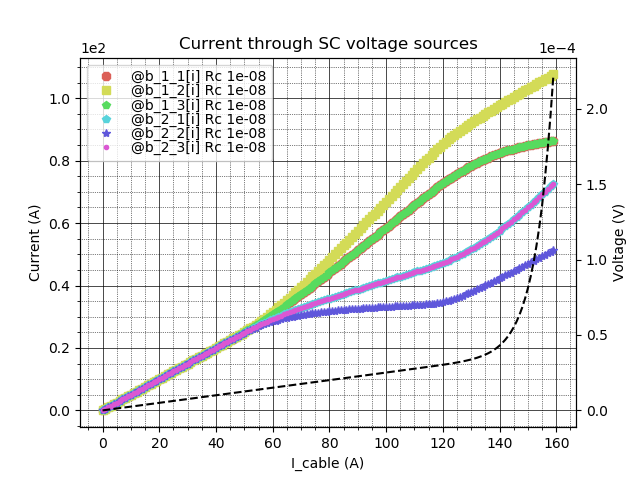

<IPython.core.display.Javascript object>


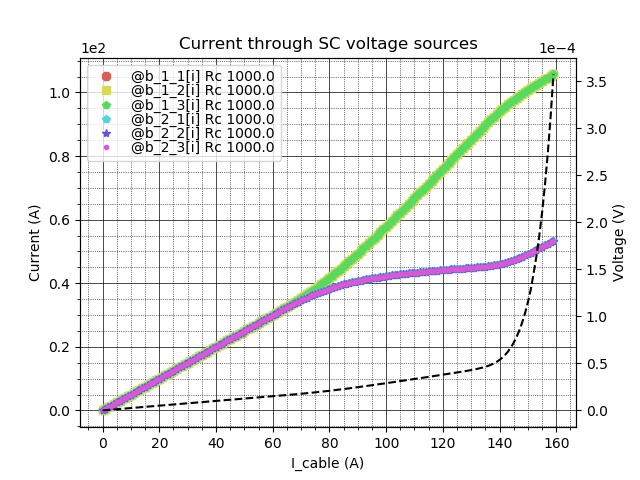

In [7]:
# Testing different values of contact resistance
sns.set_palette(sns.color_palette("hls", 6))
# Generating netlists and saving data

for i in range(len(R_cvals)):
    ns = 3 # Number of sections
    filename = f'2 tapes/2 tapes - Rc {R_cvals[i]}.cir'
    #generatenetlist(filename,Rc[i])
    dataf = readdata(filename,Labels,Data_points)
    lim_points =160
    data = dataf[:lim_points]
    fig, ax = plt.subplots()
    nc2 = 15
    for j in range(ns*2):
        ax.plot(data[:,1],data[:,j+nc2],'x',marker = markers[j],label = Labels[j+nc2]+f' Rc {R_cvals[i]}')
        
    ax.legend(labelspacing=0.001,ncol=1,loc='upper left')
    ax2 = ax.twinx()
    ax2.plot(data[:,1],data[:,2],'--k',label = 'V terminal' )
    ax.set_xlabel('I_cable (A)')
    ax.set_ylabel('Current (A)')
    ax2.set_ylabel('Voltage (V)')
    #ax2.legend(labelspacing=0.001,ncol=2,loc='lower left')
    
    plt.title('Current through SC voltage sources')
    #plt.xlim(0,200)
    ax.minorticks_on()
    ax.grid(which='major', linestyle='-', linewidth='0.5', color='black')
# Customize the minor grid
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    
    ax.tick_params(which='both') # turn off bottom ticks
    
    #plt.legend(labelspacing=0.001,ncol=2,loc='best')
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.show()
    
plt.show()



# Plotting voltage over the sections of tape 1

In this case the labesl b_i_j represent the voltage in the superconducting section, i indicates the tape number and j the number of the section.

<IPython.core.display.Javascript object>


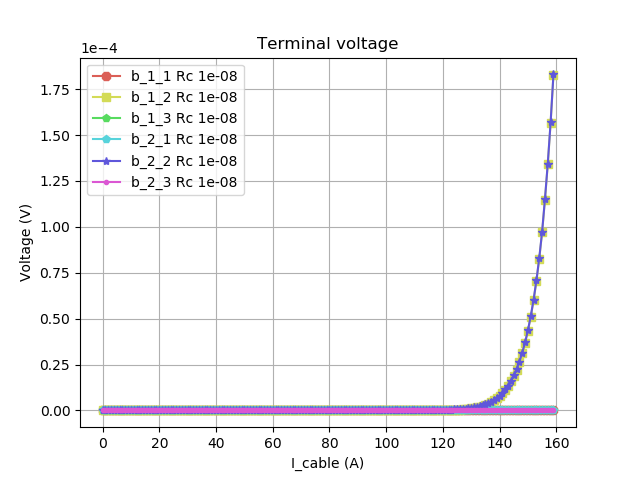

<IPython.core.display.Javascript object>


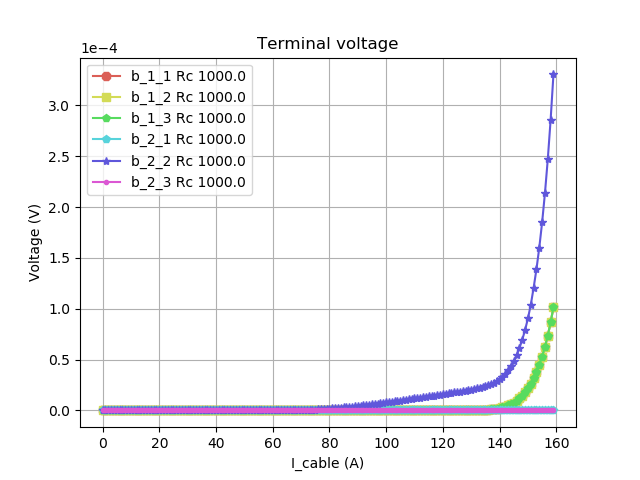

In [8]:
#%matplotlib inline
# Creating Labels for voltage
Labels_sc =[] 
for i in range(ntapes):
        for j in range(ns):
            Labels_sc.append(f'b_{i+1}_{j+1}')
#print(Labels_sc)

#R_cvals = np.array([10E-9])

for i in range(len(R_cvals)):

    Rc = np.zeros(num_rc)+R_cvals[i]
    
    #Labels, Data_points = generatingnetlist(filename,ns,ntapes,Ic,n,Rc,Imax)
    filename = f'2 tapes/2 tapes - Rc {R_cvals[i]}.cir'
    
    dataf = readdata(filename,Labels,Data_points)
    #lim = 200
    data = dataf[:lim_points]
    Icable = data[:,1]
    Vt = data[:,2]
    V_sc = np.zeros((lim_points,ns*2))
    
    markers = ["8","s","p","p","*","."]
    fig, ax = plt.subplots()
    for j in range(ns*2):
        if j<3:
            #print(f'{j+3}-{j+4}')
            V_sc[:,j] = data[:,j+3]-data[:,j+4]
            ax.plot(Icable,V_sc[:,j],marker = markers[j],label = f'{Labels_sc[j]} Rc {R_cvals[i]}')
        else:
            #print(f'{j+4}-{j+5}')
            V_sc[:,j] = data[:,j+4]-data[:,j+5]
            ax.plot(Icable,V_sc[:,j],marker = markers[j],label = f'{Labels_sc[j]} Rc {R_cvals[i]}')
    
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.xlabel('I_cable (A)')
    plt.ylabel('Voltage (V)')
    plt.title('Terminal voltage')
    plt.grid()
    plt.legend()
    plt.show()

Observations of the insulated tapes voltages (Rc = 1000 Ohm):
- The voltage in the three sections in tape 1 are overlaped. 
- The voltage in the sections at the ends of tape 2 are nearly zero.
- The higher voltage is showed by the section with defect. 

# Plotting VI curves for each superconducting section

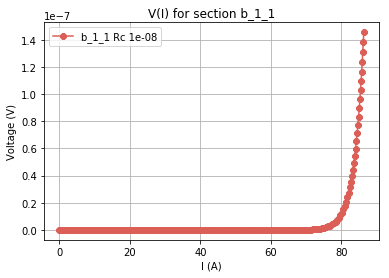

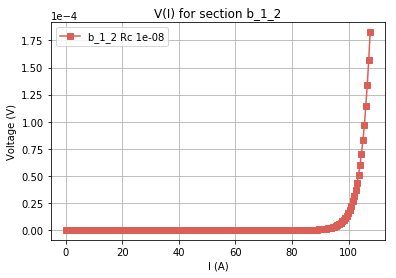

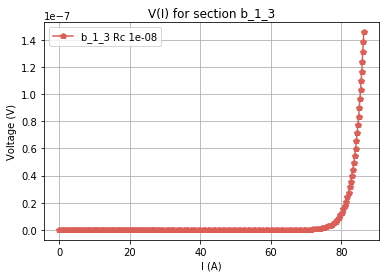

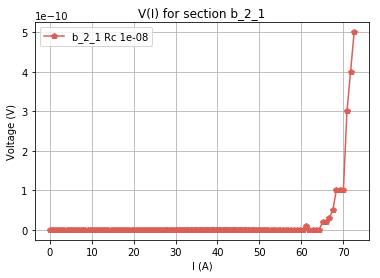

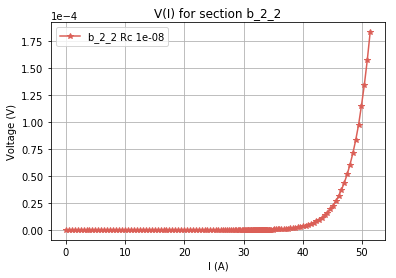

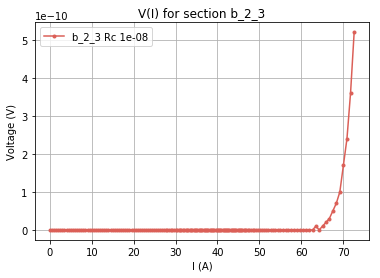

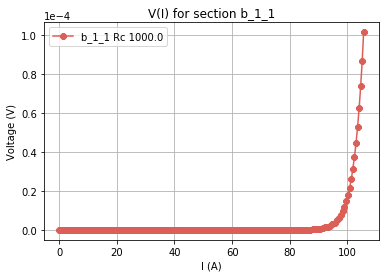

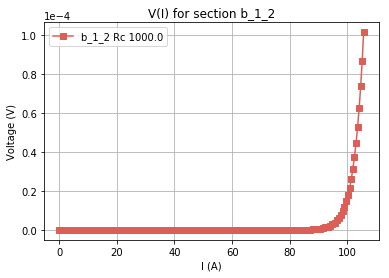

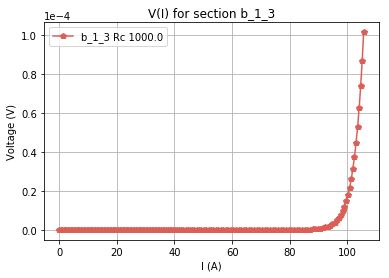

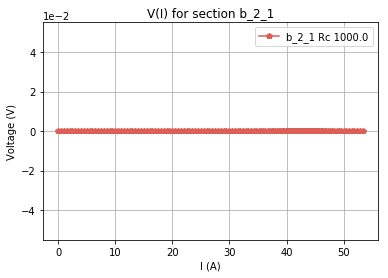

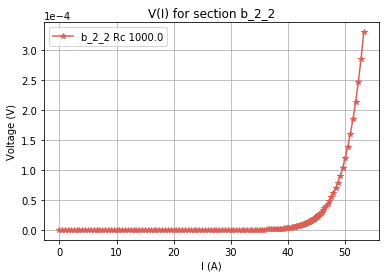

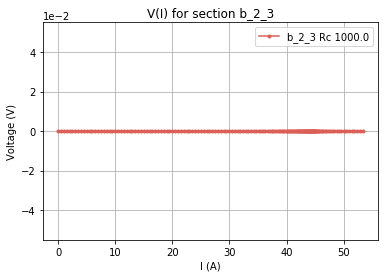

In [15]:
%matplotlib inline
# Testing different values of contact resistance
sns.set_palette(sns.color_palette("hls", 6))
# Generating netlists and saving data

for i in range(len(R_cvals)):
    ns = 3 # Number of sections
    filename = f'2 tapes/2 tapes - Rc {R_cvals[i]}.cir'
    #generatenetlist(filename,Rc[i])
    dataf = readdata(filename,Labels,Data_points)
    lim_points =160
    data = dataf[:lim_points]
    #fig, ax = plt.subplots()
    nc2 = 15
    V_sc = np.zeros((lim_points,ns*2))
    
    markers = ["8","s","p","p","*","."]
    
    for j in range(ns*2):
        #ax.plot(data[:,1],data[:,j+nc2],'x',marker = markers[j],label = Labels[j+nc2]+f' Rc {R_cvals[i]}')
    
        if j<3:
            V_sc[:,j] = data[:,j+3]-data[:,j+4]
            plt.plot(data[:,j+nc2],V_sc[:,j],marker = markers[j],label = f'{Labels_sc[j]} Rc {R_cvals[i]}')
            
        else:
            V_sc[:,j] = data[:,j+4]-data[:,j+5]
            plt.plot(data[:,j+nc2],V_sc[:,j],marker = markers[j],label = f'{Labels_sc[j]} Rc {R_cvals[i]}')
            
        plt.xlabel('I (A)')
        plt.ylabel('Voltage (V)')
        plt.title(f'V(I) for section {Labels_sc[j]}')
        plt.legend()
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        plt.grid()
        plt.show()
    

    
  
    
    



# Analysing 3 tapes with a defect in a 3-section model


- Average Ic and n value of all superconducting voltage sources is 95.13 A and 32.45, respectively.
- The defect is on tape 2 at the center. Ic and n value are 40 A and 16.
* These values are obtained from measurement.
- Length of the tape 10 cm. 

<img src="3 tapes.png">

Ic
 [[95.13 95.13 95.13]
 [95.13 40.   95.13]
 [95.13 95.13 95.13]]
n
 [[32.45 32.45 32.45]
 [32.45 16.   32.45]
 [32.45 32.45 32.45]]
Imax = 356.73749999999995
Rc 1e-08: Rt = 1.668e-07, Ic = 260.7497, n = 27.2612, Fit-error = 1.67e-07



<IPython.core.display.Javascript object>


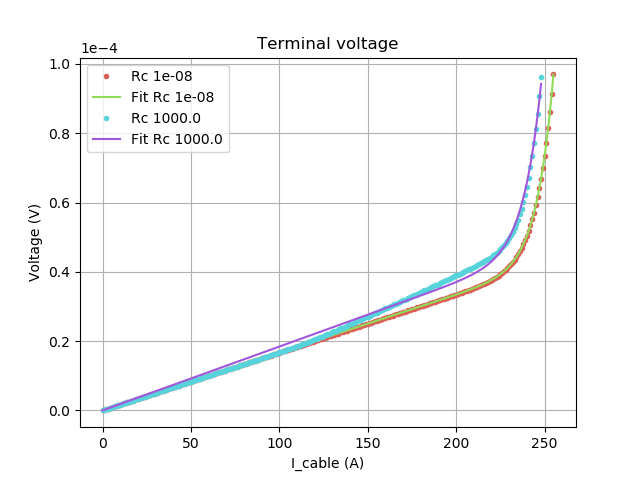

Rc 1000.0: Rt = 1.841e-07, Ic = 255.3512, n = 24.6936, Fit-error = 1.86266e-05



In [24]:
%matplotlib notebook
ntapes = 3
ns = 3
num_rc = (ns+1)*(ntapes-1)
Ic_mean = 95.13 # [A]
Ic_defect = 40 # [A]
n_mean = 32.45 
n_defect = 16
Ic = np.zeros((ntapes,ns))+Ic_mean
Ic[1,1]= Ic_defect
n = np.zeros((ntapes,ns))+n_mean
n[1,1]= n_defect
print('Ic\n',Ic)
print('n\n',n)
Imax = ntapes*Ic_mean*1.25
print(f'Imax = {Imax}')

R_cvals = np.array([1E-8,1000])

for i in range(len(R_cvals)):
    filename = f'3 tapes/3 tapes - Rc {R_cvals[i]}.cir'
    Rc = np.zeros(num_rc)+R_cvals[i]

    Labels, Data_points = generatingnetlist(filename,ns,ntapes,Ic,n,Rc,Imax)

    data = readdata(filename,Labels,Data_points)
    
    Icable = data[:,1]
    Vt = data[:,2]
    #plt.plot(Icable,Vt,label = f'Rc {Rc[i]}')
    
    Vt_lim = []
    Icable_lim = []
    # Voltage limit
    for l in range(len(Vt)):
        if Vt[l] <= 100e-6: # Limit of the total voltage
            Vt_lim.append(Vt[l])
            Icable_lim.append(Icable[l])
    
    Vt_lim = np.array(Vt_lim)
    Icable_lim = np.array(Icable_lim)
    
    # Exponential fitting
    Rt0,Ic0,n0 = 0.5E-6,100,30 # Initial values to fit exponential part
    Rt_e,Ic_e,n_e = fit_exp(Icable_lim,Vt_lim,Rt0,Ic0,n0)
    #print(Rt_e,Ic_e,n_e)

    # Getting curve from fitting 
    Vt_fit_exp = model_func(Icable_lim,Rt_e,Ic_e,n_e)

    # Calculating fitting error
    Error = np.sqrt(sum((Vt_lim-Vt_fit_exp)**2))

    # Plotting
    print(f'Rc {R_cvals[i]}: Rt = {round(Rt_e,10)}, Ic = {round(Ic_e,4)}, n = {round(n_e,4)}, Fit-error = {round(Error,10)}\n')
    plt.plot(Icable_lim,Vt_lim,'.',label = f'Rc {R_cvals[i]}')
    plt.plot(Icable_lim,Vt_fit_exp,label = f'Fit Rc {R_cvals[i]}')
    #plt.plot(Icable_lim,Vt_fit_exp,label = f'Fit Rc {Rc[i]} 3S')
    #plt.plot(data[:,1],data[:,2],label = Labels[2]+f'{ns} sections- Rc {R_cvals[i]}')

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel('I_cable (A)')
plt.ylabel('Voltage (V)')
plt.title('Terminal voltage')
#plt.ylim(0,100E-6)
#plt.xlim(0,200)
plt.grid()
plt.legend()
plt.show()

# Plotting voltage over the sections of tape 1

In this case the labesl b_i_j represent the voltage in the superconducting section, i indicates the tape number and j the number of the section.